In [1]:
# !pip install -q --upgrade transformers diffusers ftfy

# Setup

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading model

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

0it [00:00, ?it/s]

0 loss: 182.04074096679688
10 loss: 43.539833068847656
20 loss: 15.325596809387207
30 loss: 9.699049949645996
40 loss: 8.799238204956055


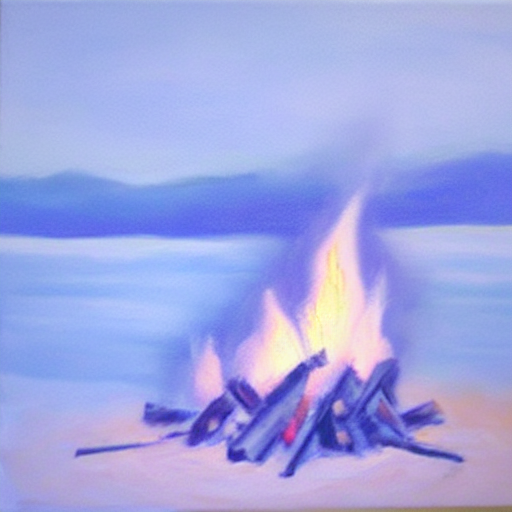

In [6]:
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #@param

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = blue_loss(denoised_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

# Fix object

In [12]:
import numpy as np
object_image = Image.open("/home/ubuntu/input_data_white/0001.png")
object_image.thumbnail((512, 512))
object_im_tensor = tfms.ToTensor()(object_image).unsqueeze(0).to(torch_device)
mask_image = Image.open("/home/ubuntu/input_data_white/mask/0001_mask.png")
mask_image.thumbnail((512, 512))
mask_im_tensor = tfms.ToTensor()(mask_im_np).unsqueeze(0).to(torch_device) * 255

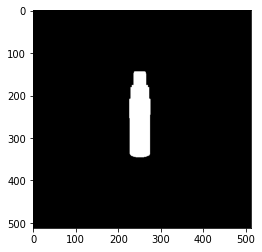

In [18]:
plt.imshow(np.array(mask_image)*255)

In [14]:
print(torch.max(object_im_tensor),torch.min(object_im_tensor),object_im_tensor.shape)
print(torch.max(mask_im_tensor),torch.min(mask_im_tensor),mask_im_tensor.shape)
print(object_im_tensor.requires_grad)
print(mask_im_tensor.requires_grad)

tensor(1., device='cuda:0') tensor(0.0275, device='cuda:0') torch.Size([1, 3, 512, 512])
tensor(1., device='cuda:0') tensor(0., device='cuda:0') torch.Size([1, 3, 512, 512])
False
False


In [9]:
def mask_loss(output_im, object_im, mask_im):
    # How far are the blue channel values to 0.9:
    error = torch.abs(output_im * mask_im - object_im * mask_im).mean() # [:,2] -> all images in batch, only the blue channel
    return error

# Fix object and background

In [65]:
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 300 #@param

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    noise_pred = noise_pred_text
    # noise_pred = noise_pred_uncond
    
    #### ADDITIONAL GUIDANCE ###
    if i%1 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        # loss = blue_loss(denoised_images) * blue_loss_scale
        loss = mask_loss(denoised_images, object_im_tensor, mask_im_tensor) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


output_img = latents_to_pil(latents)[0]

0it [00:00, ?it/s]

0 loss: 6.402137756347656
10 loss: 6.879821300506592
20 loss: 5.008216381072998
30 loss: 3.7756640911102295
40 loss: 3.0901224613189697


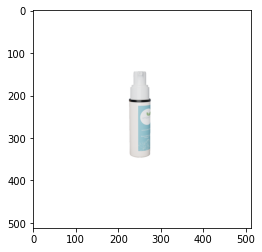

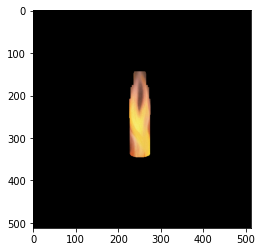

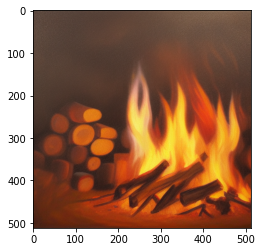

In [66]:
output_np = np.array(output_img)
mask_np = np.array(mask_image)
plt.imshow(object_image)
plt.show()
plt.imshow(output_np * mask_np)
plt.show()
plt.imshow(output_np)
plt.show()

In [50]:
np.max(mask_np),np.min(mask_np),mask_np.shape

(1.0, 0.5, (512, 512, 3))

In [ ]:
np.max(mask_np),np.min(mask_np),mask_np.shape